# Self Attention module implemented from SAGAN

### Libraries Used

- tensorflow
- sklearn
- numpy
- matplotlib
- pandas
- scipy
- tensorflow_probability


## Initial setup

### Install Libraries

In [ ]:
%pip install tensorflow numpy matplotlib scipy tensorflow_probability pandas spectral

### Mount Google Drive

In [6]:
# from google.colab import drive
# drive.mount('/content/drive/')

### Timer Function

In [8]:
from time import time

def timeIt(func):
    """
    timeIt is a decorator function to time the execution of a function.

    :param func: function to be timed
    :return: wrapper function
    """
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

### Import Libraries

In [9]:
import random
import statistics
import os
from IPython.display import clear_output

from operator import truediv

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K

from tensorflow.keras import Sequential, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.compat.v1.distributions import Bernoulli
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)



## Global Variables

In [10]:

# Test each code block individually
TEST_BLOCKS: bool = False
EXECUTIONER: str = 'Aditya' # Name of Executioner
RUN: int  = 1 # Defines the current no of run no.

DRIVE: bool = False
# Data Loading and Preprocessing

# Dataset Used : Indian Pines
DATASET: str = 'IP' # 'IP', 'SA', 'PU'
DRIVE_PATH: str = '/content/drive/MyDrive/' if DRIVE else 'E:/Engginearing/SAKEC/SEM 6/Major Project/'

PATH_TO_DATASET: str = f'{DRIVE_PATH}/Datasets/'
# PATH_TO_DATASET: str = 'E:\Engginearing\SAKEC\SEM 6\Major Project\Data\\'
NUM_CLASSES: int = 16

# PCA
PCA_COMPONENTS: int = 30 # Number of components to keep after PCA reduction

# Window size for forming image cubes
WINDOW_SIZE: int = 11

WIDTH: int
HEIGHT: int

# Image dimensions after forming image cubes
IMAGE_WIDTH: int
IMAGE_HEIGHT: int
IMAGE_DEPTH: int
IMAGE_CHANNEL: int
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, IMAGE_CHANNEL = 11, 11, 30, 1

# Model Parameters

N_TIMES: int = 5 # Number of times to run the model. Internally, the model is runs each episode N_TIMES times

# Learning Rate
LEARNING_RATE: float = 0.00001

# Temparature Scaling
TAU: float = 1  # 1 or 1.8

# Train / Test Ratio

TEST_RATIO: int = 0.3


OUTPUT_UNITS = 9 if (DATASET == 'PU' or DATASET == 'PC') else 16

common = f'{EXECUTIONER}/{DATASET}_{RUN}'

CHECKPOINT_PATH=f'{DRIVE_PATH}New Code/{common}/best-model.hdf5'
REPORT=f'{DRIVE_PATH}New Code/{common}/classification_report.txt'
GT=f'{DRIVE_PATH}New Code/{common}/ground_truth.jpg'
PRED=f'{DRIVE_PATH}New Code/{common}/prediction.jpg'

# checkpoint_dir = f'/content/drive/My Drive/Models/{EXECUTIONER}/{DATASET}/{N_TIMES}/{TAU}/{RUN}'
# checkpoint_prefix_train = os.path.join(checkpoint_dir, "ckpt")

# checkpoint_dir1 = f'/content/drive/My Drive/Models/{EXECUTIONER}/{DATASET}/{N_TIMES}/{TAU}/{RUN}/Tune'
# checkpoint_prefix_tune = os.path.join(checkpoint_dir1, "ckpt")

checkpoint = None  # To be used for loading checkpoints. Declared in the Main Block
ProtoModel = None  # Prototypical Network Object. Declared in the Main Block
model = None  # Model Object. Declared in the Main Block
optimizer = None  # Optimizer Object. Declared in the Main Block

In [11]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  []


## Data Loading and Preprocessing

In [6]:
def loadData(name: str) -> (np.ndarray, np.ndarray):
    '''
     loadData loads the data from the .mat files

     :param name: name of the dataset
     :return: (data, labels)
    '''
    
    if(name == 'IP'):
        data = sio.loadmat(f'{PATH_TO_DATASET}indian_pines_corrected.mat')[ f'indian_pines_corrected']
        labels = sio.loadmat(f'{PATH_TO_DATASET}indian_pines_gt.mat')[ f'indian_pines_gt']
    elif(name == 'SA'):
        data = sio.loadmat(f'{PATH_TO_DATASET}salinas_corrected.mat')[ f'salinas_corrected']
        labels = sio.loadmat(f'{PATH_TO_DATASET}salinas_gt.mat')[ f'salinas_gt']
    elif(name == 'PU'):
        data = sio.loadmat(f'{PATH_TO_DATASET}PaviaU.mat')[ f'paviaU']
        labels = sio.loadmat(f'{PATH_TO_DATASET}PaviaU_gt.mat')[ f'paviaU_gt']

    HEIGHT = labels.shape[0]
    WIDTH = labels.shape[1]

    return data, labels

if(TEST_BLOCKS):
  print(loadData('indian_pines'))

In [7]:
def applyFA(X: np.ndarray, n_components: int = 30) -> np.ndarray:
    """
    applyFA reduces the dimensionality of the data using Factor Analysis.

    :param X: The data to be reduced.
    :param n_components: The number of components to keep.
    :return: The data with reduced dimensionality.
    """

    fa = FactorAnalysis(n_components=n_components, random_state=0) # create a FA object
    new_X = np.reshape(X, (-1, X.shape[2])) # reshape the data into a 2D matrix
    new_X = fa.fit_transform(new_X) # fit the FA object
    new_X = np.reshape(new_X, (X.shape[0], X.shape[1], n_components)) # reshape the data into a 3D matrix
    del fa # delete the PCA object
    return new_X

if(TEST_BLOCKS):
    # TODO: Implement a test for applyPCA
    pass

In [8]:
def applyPCA(X: np.ndarray, n_components: int = 30) -> np.ndarray:
    """
    applyPCA reduces the dimensionality of the data using PCA.

    :param X: The data to be reduced.
    :param n_components: The number of components to keep.
    :return: The data with reduced dimensionality.
    """

    pca = PCA(n_components=n_components, whiten=True) # create a PCA object
    new_X = np.reshape(X, (-1, X.shape[2])) # reshape the data into a 2D matrix
    new_X = pca.fit_transform(new_X) # fit the PCA object
    new_X = np.reshape(new_X, (X.shape[0], X.shape[1], n_components)) # reshape the data into a 3D matrix
    del pca # delete the PCA object
    return new_X

if(TEST_BLOCKS):
    # TODO: Implement a test for applyPCA
    pass

In [9]:
def splitTrainTestSet(X: np.ndarray, y: np.ndarray, testRatio: int, randomState:int = 345):
    """
    
    """
    return train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    
    

In [10]:

def padWithZeros(X: np.ndarray, margin:int) -> np.ndarray:
    """
    padWithZeros pads the input array X with zero margins in height and width dimensions.

    :param X: input array of shape (W, H, C).
    :param margin: number of zeros to pad on each side of the height and width dimensions.
    :return: X padded with zeros of shape (W + 2*margin, H + 2*margin, C).
    """
    return np.pad(X, ((margin,margin), (margin,margin), (0,0)), 'constant', constant_values=0)
    # Previous implementation
    # newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    # x_offset = margin
    # y_offset = margin
    # newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    # return newX

if(TEST_BLOCKS):
    test_X = np.random.randn( 3, 3, 2)
    test_margin = 2
    print(padWithZeros(test_X, test_margin))

In [11]:
@timeIt
def createImageCubes(X: np.ndarray, Y: np.ndarray, windowSize: int, removeZeroLabels=True) -> (np.ndarray, np.ndarray):
    """
    createImageCubes creates image cubes from the given image and label data. Only height and width are considered for the image cube creation. The depth of the image cube is the number of bands in the image. The depth is preserved from the input image.

    :param X: input image
    :param Y: input label
    :param windowSize: size of the image cube to be created. Height and width of the image cube is (windowSize, windowSize)
    :return (dataPatches, dataLabels): dataPatches is a list of image cubes. dataLabels is a list of labels corresponding to the image cubes in dataPatches

    Algorithm:
    - Calculate the margin to be padded to the image.
    - Pad the image with zeros.
    - Create image cubes from the padded image.
    - Expand the dimensions of the image cubes to include the channel dimension.
    - Create labels for the image cubes.
    - Return the image cubes and labels.
    """

    margin = int(windowSize // 2)
    zeroPaddedX = padWithZeros(X, margin)
    dataPatches = [zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1] for r in range(margin, zeroPaddedX.shape[0] - margin) for c in range(margin, zeroPaddedX.shape[1] - margin)]
    dataPatches = np.expand_dims(dataPatches, axis=-1)
    dataLabels = np.array([Y[r-margin, c-margin] for r in range(margin, zeroPaddedX.shape[0] - margin) for c in range(margin, zeroPaddedX.shape[1] - margin)])
   
    if removeZeroLabels:
        dataPatches = dataPatches[dataLabels>0,:,:,:]
        dataLabels = dataLabels[dataLabels>0]
        dataLabels -= 1
    
    return dataPatches, dataLabels

if(TEST_BLOCKS):
    ip_x1, ip_y = loadData(DATASET)
    ip_x2 = applyPCA(ip_x1,n_components=30)
    ip_X,ip_Y = createImageCubes(ip_x2, ip_y, windowSize=IMAGE_WIDTH)
    print(ip_X.shape, ip_Y.shape)

## Model

### Model Construction


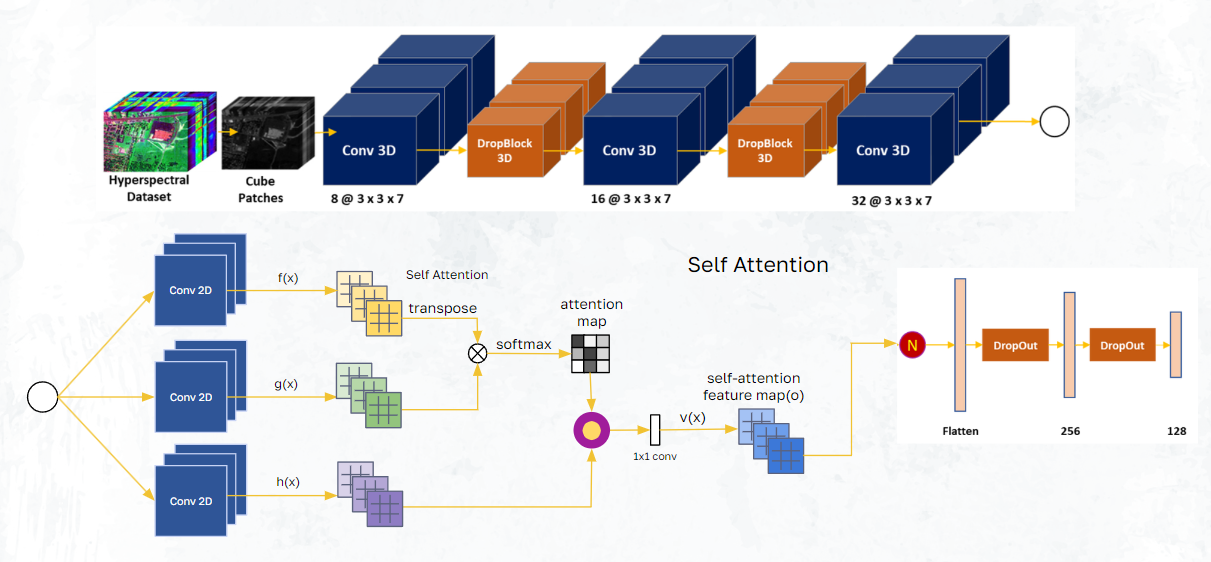

In [12]:
def createModel():
    """
    createModel() function creates the model architecture for the 3D CNN model.
    :return: model

    The model architecture is as follows:
    1. Input layer
    2. 3D Convolution layer with 8 filters, kernel size (3,3,7), activation function 'relu' and padding 'same'
    3. Spatial Dropout layer with dropout rate 0.3
    4. 3D Convolution layer with 16 filters, kernel size (3,3,5), activation function 'relu' and padding 'same'
    5. Spatial Dropout layer with dropout rate 0.3
    6. 3D Convolution layer with 32 filters, kernel size (3,3,3), activation function 'relu'
    7. Reshape layer to reshape the output of 3D Convolution layer to 2D
    8. 2D Convolution layer with 64 filters, kernel size (3,3), activation function 'relu'
    9. Attention layer with score mode a 'dot' applied on 2D Conv Layer (prev)
    10. Softmax Normalization of Attention layer
    11. Concatenation Attention of Normalized Attention layer and 2D Conv Layer (step 8)
    12. Flatten layer to flatten the output of 2D Convolution layer
    13. Dropout layer with dropout rate 0.4
    14. Dense layer with 256 neurons and activation function 'relu'
    15. Dropout layer with dropout rate 0.4
    16. Dense layer with 128 neurons and activation function 'relu'
    17. Output layer with 128 neurons and activation function 'relu'

    """

    input_layer = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, IMAGE_CHANNEL))

    output_layer_1_conv = layers.Conv3D(filters=8, kernel_size=(3,3,7), activation='relu',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, IMAGE_CHANNEL),padding='same')(input_layer)

    output_layer_1_drop3d = layers.SpatialDropout3D(rate=0.3, data_format='channels_last')(output_layer_1_conv,training=True)

    output_layer_2_conv = layers.Conv3D(filters=16, kernel_size=(3,3,5), activation='relu',padding='same')(output_layer_1_drop3d)

    output_layer_2_drop3d = layers.SpatialDropout3D(rate=0.3, data_format='channels_last')(output_layer_2_conv,training=True)

    output_layer_3_conv = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation= 'relu')(output_layer_2_drop3d)


    output_layer_3_reshaped = layers.Reshape((output_layer_3_conv.shape[1], output_layer_3_conv.shape[2], output_layer_3_conv.shape[3]*output_layer_3_conv.shape[4]))(output_layer_3_conv)

    output_layer_4_conv = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(output_layer_3_reshaped)

    output_layer_5_SA_dot = layers.Attention()([output_layer_4_conv, output_layer_4_conv])

    output_layer_5_softmax = layers.Softmax()(output_layer_5_SA_dot)

    output_layer_5_SA_concat = layers.Attention(score_mode='concat')([output_layer_5_softmax, output_layer_4_conv])

    output_layer_5_normalization = layers.LayerNormalization()(output_layer_5_SA_concat)

    output_layer_6_flatten = layers.Flatten()(output_layer_5_normalization)

    output_layer_6_drop = layers.Dropout(rate=0.4)(output_layer_6_flatten,training=True)

    output_layer_6_dense = layers.Dense(256, activation='relu')(output_layer_6_drop)

    output_layer_7_drop = layers.Dropout(0.4)(output_layer_6_dense,training=True)

    output_layer_7_dense = layers.Dense(128, activation='relu')(output_layer_7_drop)
    
    output_layer_8_drop = layers.Dropout(0.4)(output_layer_6_dense,training=True)
    
    output_layer_8 = layers.Dense(units=OUTPUT_UNITS, activation='softmax')(output_layer_8_drop)
    
    
    model = Model(inputs=input_layer, outputs=output_layer_8)
    # plot_model(model, to_file='/content/drive/My Drive/Models/saGanTry.png')
    # print(model.summary())
    return model

m = createModel()
print(m.summary())
del m

if(TEST_BLOCKS):
    model = createModel()
    print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11, 11, 30, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 11, 11, 30, 8)        512       ['input_1[0][0]']             
                                                                                                  
 spatial_dropout3d (Spatial  (None, 11, 11, 30, 8)        0         ['conv3d[0][0]']              
 Dropout3D)                                                                                       
                                                                                                  
 conv3d_1 (Conv3D)           (None, 11, 11, 30, 16)       5776      ['spatial_dropout3d[0][0]'

## Main

In [13]:
# # Load Dataset
# X, Y = loadData(DATASET)

# # Apply PCA to reduce dimensionality of the data
# X_pca = applyPCA(X, n_components=PCA_COMPONENTS)

# # Create Image Cubes from data, and labels
# X_cubes, Y_cubes = createImageCubes(X_pca, Y, windowSize=WINDOW_SIZE)

# # Creates class wise patches from the image cubes
# patches = classWisePatches(X_cubes, Y_cubes)

# # Seperate the patches into train and test sets
# TRAINING_PATCHES: list = [patches[i] for i in TRAINING_CLASSES]
# TESTING_PATCHES: list = [patches[i] for i in TESTING_CLASSES]

# # Create instance of the model
# model = createModel()

# # Create instance of the Prototypical Network
# ProtoModel = Prototypical(model, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, IMAGE_CHANNEL)

# # Create instance of the Optimizer
# optimizer = Adam(learning_rate=LEARNING_RATE)

# # Create instance of the Checkpoint
# checkpoint = tf.train.Checkpoint(optimizer=optimizer, ProtoModel = ProtoModel)

# # Train the model
# trainingEpochs(patches, TRAINING_LABELS, TRAINING_EPOCH, TRAINING_EPISODE)

# TUNNING_PATCHES = [TESTING_PATCHES[i][:5,:,:,:,:] for i in range(6)]

# tunningEpochs(TUNNING_PATCHES, TESTING_LABELS, TUNNING_EPOCH, TUNNING_EPISODE)

# mc_predictions1, mc_predictions2, y1, y2=  testingEpochs(TESTING_PATCHES, TESTING_LABELS, TESTING_EPOCH)

# calculateAccuracy(mc_predictions1, mc_predictions2, y1, y2)

# overall_true_labels, overall_predictions = calculateConfusionMatrix(mc_predictions1, mc_predictions2, y1, y2)

# calculateKappaScore(overall_true_labels, overall_predictions)

# plotData(trainingData, testing=False, clear=False)
# plotData(tunningData, testing=False, clear=False)
# plotData(testingData, testing=True, clear=False)


In [14]:
# Load Dataset
X, Y = loadData(DATASET)

# Apply PCA to reduce dimensionality of the data
X_fa = applyFA(X, n_components=PCA_COMPONENTS)

# Create Image Cubes from data, and labels
X_cubes, Y_cubes = createImageCubes(X_fa, Y, windowSize=WINDOW_SIZE)

# Split Data into Training and Testing Sets
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_cubes, Y_cubes, TEST_RATIO)

Xtrain = Xtrain.reshape(-1, WINDOW_SIZE, WINDOW_SIZE, PCA_COMPONENTS, 1)

ytrain = to_categorical(ytrain)

model = createModel()

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='acc', verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoint]

Function 'createImageCubes' executed in 0.4187s


In [15]:
history = model.fit(x=Xtrain, y=ytrain, batch_size = 30, epochs=150, callbacks=callbacks_list)

Epoch 1/150
240/240 [==============================] - ETA: 0s - loss: 2.9964 - accuracy: 0.1786
Epoch 1: saving model to E:/Engginearing/SAKEC/SEM 6/Major Project/New Code/Aditya/IP_1\best-model.hdf5
240/240 [==============================] - 95s 390ms/step - loss: 2.9964 - accuracy: 0.1786
Epoch 2/150


C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



240/240 [==============================] - ETA: 0s - loss: 2.1650 - accuracy: 0.3352
Epoch 2: saving model to E:/Engginearing/SAKEC/SEM 6/Major Project/New Code/Aditya/IP_1\best-model.hdf5
240/240 [==============================] - 96s 401ms/step - loss: 2.1650 - accuracy: 0.3352
Epoch 3/150
165/240 [===================>..........] - ETA: 35s - loss: 1.7921 - accuracy: 0.4400

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.show()

In [ ]:
model.load_weights(CHECKPOINT_PATH)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, WINDOW_SIZE, WINDOW_SIZE, PCA_COMPONENTS, 1)
Xtest.shape

In [ ]:
ytest = to_categorical(ytest)
ytest.shape

In [ ]:
def temperature_scaling(logits, temperature):
    scaled_logits = logits / temperature
    return scaled_logits

In [ ]:
Y_pred_test = model.predict(Xtest)

# Temperature Scaling
scaled_Y_pred_test = temperature_scaling(Y_pred_test, TAU)

y_pred_test = np.argmax(scaled_Y_pred_test, axis=1)
 
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc
    
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100
    
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,DATASET)

In [ ]:
classification = str(classification)
confusion = str(confusion)

with open(REPORT, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

print('{} Kappa accuracy (%)'.format(kappa))
print('{} Overall accuracy (%)'.format(oa))
print('{} Average accuracy (%)'.format(aa))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch
    
X, y = loadData(DATASET)

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = WINDOW_SIZE

X = X_fa

X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# # calculate the predicted image
# outputs = np.zeros((height,width))
# total = height*width
# current = 0
# for i in range(height):
#     for j in range(width):
#         target = int(y[i,j])
#         if target == 0 :
#             continue
#         else :
#             current+=1
#             print(f'{current} / {total}', end=' ')
#             image_patch=Patch(X,i,j)
#             X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
#             prediction = (model.predict(X_test_image))
#             prediction = np.argmax(prediction, axis=1)
#             outputs[i][j] = prediction+1
#             del image_patch
#             del prediction
#             del X_test_image

In [ ]:
outputs = np.zeros((height,width))

# Define the batch size (number of patches to process in each batch)
batch_size = 32  # You can adjust this based on available memory

# Initialize an empty list to store batch predictions
batch_predictions = []

for i in range(0, height, batch_size):
    for j in range(0, width, batch_size):
        # Create empty arrays to store batch data
        batch_X_test_image = []
        batch_indices = []

        # Loop through the batch indices
        for u in range(i, min(i + batch_size, height)):
            for v in range(j, min(j + batch_size, width)):
                target = int(y[u, v])
                if target != 0:
                    image_patch = Patch(X, u, v)
                    image_patch = image_patch.reshape(image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
                    batch_X_test_image.append(image_patch)
                    batch_indices.append((u, v))
    
        # If there are patches in this batch, process them
        if batch_X_test_image:
            batch_X_test_image = np.array(batch_X_test_image).astype('float32')
            batch_prediction = model.predict(batch_X_test_image)

            # Loop through batch indices and store predictions in outputs
            for k, (u, v) in enumerate(batch_indices):
                prediction = np.argmax(batch_prediction[k])
                outputs[u][v] = prediction + 1

            # Release memory occupied by the batch data
            del batch_X_test_image, batch_indices, batch_prediction

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb(PRED, outputs.astype(int), colors=spectral.spy_colors)

In [ ]:
spectral.save_rgb(GT, y, colors=spectral.spy_colors)